In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist, obs_hci
from pynrc.obs_nircam import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [19]:
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u

from astropy.convolution import convolve, convolve_fft
from scipy import fftpack

import pysiaf

## Read in stellar photometry

In [4]:
# Read in master source table and FITS file
tbl = ascii.read('MASTER.ISO.XYVJHKRD.txt')

In [5]:
names = ['Color', 'ACS_F606W', 'F210M', 'F335M', 'RA', 'Dec']
include_names = names[2:4]
tbl2 = ascii.read('MASTER.ISO.NRC.F210M.F335M.txt', names=names, include_names=include_names)
for k in tbl2.keys():
    tbl.add_column(tbl2[k])

In [6]:
names = ['Color', 'ACS_F606W', 'F200W', 'F356W', 'RA', 'Dec']
include_names = names[2:4]
tbl2 = ascii.read('MASTER.ISO.NRC.F200W.F356W.txt', names=names, include_names=include_names)
for k in tbl2.keys():
    tbl.add_column(tbl2[k])

In [7]:
names = ['Color', 'ACS_F606W', 'F200W', 'F444W', 'RA', 'Dec']
include_names = names[3:4]
tbl2 = ascii.read('MASTER.ISO.NRC.F200W.F444W.txt', names=names, include_names=include_names)
for k in tbl2.keys():
    tbl.add_column(tbl2[k])

In [8]:
tbl

x,y,vcal,jcal,hcal,kcal,j2mass,h2mass,k2mass,jmodel,hmodel,kmodel,juse,huse,kuse,ra,dec,F210M,F335M,F200W,F356W,F444W
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3313.07,744.06,21.044,30.0,30.0,30.0,30.0,30.0,30.0,19.517,19.048,18.98,19.517,19.048,18.98,80.37930584,-69.47107232,18.98164,18.93709,18.99291,18.93495,18.98836
3486.84,747.89,20.787,30.0,30.0,30.0,30.0,30.0,30.0,19.24,18.763,18.695,19.24,18.763,18.695,80.38441657,-69.46947496,18.69659,18.65135,18.70799,18.64916,18.70393
3415.99,748.84,21.502,30.0,30.0,30.0,30.0,30.0,30.0,20.02,19.568,19.503,20.02,19.568,19.503,80.38240033,-69.47015164,19.50474,19.46174,19.51572,19.45972,19.50997
3550.82,750.81,21.823,30.0,30.0,30.0,30.0,30.0,30.0,20.629,20.284,20.239,20.629,20.284,20.239,80.38633863,-69.46890205,20.24143,20.20625,20.25063,20.20481,20.23536
3521.42,752.24,20.733,30.0,30.0,30.0,30.0,30.0,30.0,19.182,18.703,18.634,19.182,18.703,18.634,80.38552984,-69.46919333,18.63558,18.59016,18.64701,18.58796,18.64307
3339.04,753.49,21.96,30.0,30.0,30.0,30.0,30.0,30.0,20.871,20.562,20.524,20.871,20.562,20.524,80.38030749,-69.47092313,20.52665,20.49359,20.53525,20.49231,20.51625
3605.54,756.67,21.409,30.0,30.0,30.0,30.0,30.0,30.0,19.916,19.459,19.393,19.916,19.459,19.393,80.3880727,-69.46844602,19.39472,19.35132,19.40576,19.34927,19.40034
3633.2,756.98,21.918,30.0,30.0,30.0,30.0,30.0,30.0,20.809,20.494,20.454,20.809,20.494,20.454,80.388878,-69.4681887,20.45661,20.42317,20.46532,20.42186,20.44703
3349.24,759.33,21.955,30.0,30.0,30.0,30.0,30.0,30.0,20.863,20.554,20.516,20.863,20.554,20.516,80.38075825,-69.47088612,20.51865,20.48554,20.52726,20.48426,20.50834


In [77]:
# Turn RA/Dec into Skycoords
ra_deg, dec_deg = (tbl['ra'], tbl['dec'])
data_coords = SkyCoord(ra_deg, dec_deg, unit=u.deg, frame='icrs') 

## Get calibration field WCS

In [82]:
hdul = fits.open('JWST_CALIBFIELD_WCS.fits')
hdu = hdul[0]

# Set up a WCS for for the image
wcs = WCS(hdu.header)

## Plot apertures on calib field

In [268]:
# Import pySIAF and get aperture locations
from pysiaf.siaf import plot_master_apertures, plot_main_apertures

siaf = pysiaf.Siaf('NIRCam')
nrcall = siaf['NRCALL_FULL']
nrca5 = siaf['NRCA5_FULL']
nrcb5 = siaf['NRCB5_FULL']
nrca5_mask = siaf['NRCA5_FULL_MASK430R']

In [269]:
# RA, Dec, and PA of NRCALL_FULL reference location
ra_ref, dec_ref = (80.48750, -69.49750)
pa_ref = 0

# Field offset as specified in APT Special Requirements
x_off, y_off  = (-60,0)
x_off += -38.157
y_off += -13.687

# V2/V3 reference location aligned with RA/Dec reference
v2_ref, v3_ref = np.array(nrcall.reference_point('tel'))

# Attitude correction matrix relative to NRCALL_FULL aperture
att = pysiaf.utils.rotations.attitude(v2_ref-x_off, v3_ref+y_off, ra_ref, dec_ref, pa_ref)

# Convert all RA/Dec coordinates into V2/V3 positions for objects
v2_obj, v3_obj = pysiaf.utils.rotations.getv2v3(att, ra_deg, dec_deg)

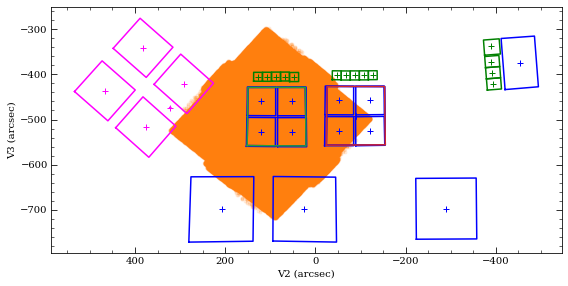

In [272]:
# Plot aperture files
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(v2_obj, v3_obj, marker='.', alpha=0.1, ls='None', color='C1')

plot_main_apertures(ax=ax, fill=False, mark_ref=True)

nrca5.plot(ax=ax, fill=False, fill_alpha=0.3, fill_color='C2', color='C2')
nrcb5.plot(ax=ax, fill=False, fill_alpha=0.3, fill_color='C3', color='C3')

fig.tight_layout()

In [81]:
# Convert aperture V2/V3 vertices to RA/Dec
v2_a5_mask, v3_a5_mask = nrca5_mask.closed_polygon_points('tel', rederive=False)
v2_a5, v3_a5 = nrca5.closed_polygon_points('tel', rederive=False)
v2_b5, v3_b5 = nrcb5.closed_polygon_points('tel', rederive=False)

ra_a5_mask, dec_a5_mask = pysiaf.utils.rotations.pointing(att, v2_a5_mask, v3_a5_mask)
ra_a5, dec_a5 = pysiaf.utils.rotations.pointing(att, v2_a5, v3_a5)
ra_b5, dec_b5 = pysiaf.utils.rotations.pointing(att, v2_b5, v3_b5)

a5_coord_mask = SkyCoord(ra_a5_mask, dec_a5_mask, unit='deg', frame='icrs') 
a5_coord = SkyCoord(ra_a5, dec_a5, unit='deg', frame='icrs')
b5_coord = SkyCoord(ra_b5, dec_b5, unit='deg', frame='icrs') 

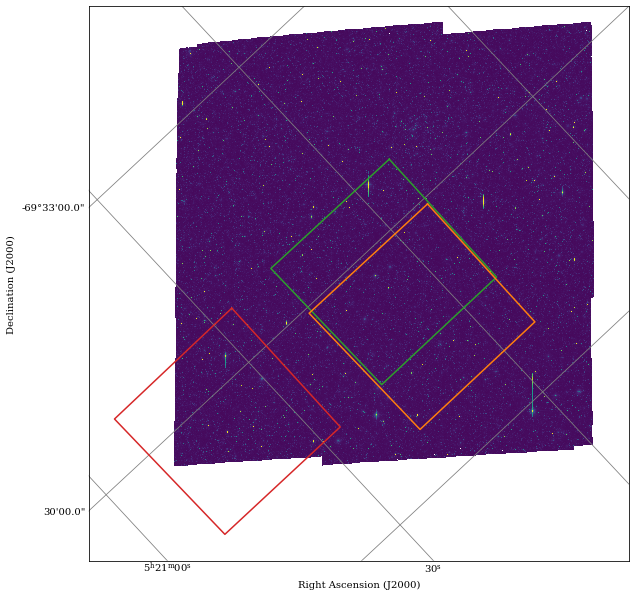

In [87]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax = plt.subplot(projection=wcs)
ax.imshow(hdu.data**0.5)

ax.coords.grid(color='gray', linestyle='solid')
lon = ax.coords[0]
lat = ax.coords[1]

lon.set_axislabel('Right Ascension (J2000)')
lat.set_axislabel('Declination (J2000)')

lon.set_major_formatter('hh:mm:ss')
lat.set_major_formatter('dd:mm:ss.s')

#lon.display_minor_ticks(False)
#lat.display_minor_ticks(False)

lon.set_ticks_visible(False)
lat.set_ticks_visible(False)

#plt.grid(color='black')
#plt.tick_params(axis='both', which='major', grid_linestyle='solid', grid_color='black')
#plt.tick_params(axis='both', which='major', length=0)
#plt.tick_params(axis='both', which='minor', length=0)

ax.plot_coord(a5_coord, color='C2')
ax.plot_coord(a5_coord_mask, color='C1')
ax.plot_coord(b5_coord, color='C3')

fig.tight_layout()

## Simulate field

In [246]:
def obj_v2v3(tbl_objs, ap_ref, coord_ref, pa_ref, base_off=(0,0), dith_off=(0,0)):
    """
    Convert objects to V2/V3 coordinates
    
    tbl_objs  : Table of object positions and filter mags
    ap_ref    : Aperture name ('NRCALL_FULL') of reference coordinates
    coord_ref : List or tuple of RA & Dec towards which ap_ref points
    pa_ref    : Position angle of ap_ref

    base_off   : X/Y offset of overall aperture offset (see APT pointing file)
    dither_off : Additional offset from dithering (see APT pointing file)


    """
    
    siaf = pysiaf.Siaf('NIRCAM')
    ap_siaf = siaf[ap_ref]

    # RA and Dec of ap ref location and the objects in the field
    ra_ref, dec_ref = coord_ref
    ra_obj, dec_obj = (tbl_objs['ra'], tbl_objs['dec'])

    # Field offset as specified in APT Special Requirements
    x_off, y_off  = (base_off[0] + dith_off[0], base_off[1] + dith_off[1])

    # V2/V3 reference location aligned with RA/Dec reference
    v2_ref, v3_ref = np.array(ap_siaf.reference_point('tel'))

    # Attitude correction matrix relative to NRCALL_FULL aperture
    att = pysiaf.utils.rotations.attitude(v2_ref-x_off, v3_ref+y_off, ra_ref, dec_ref, pa_ref)

    # Convert all RA/Dec coordinates into V2/V3 positions for objects
    v2_obj, v3_obj = pysiaf.utils.rotations.getv2v3(att, ra_obj, dec_obj)

    return (v2_obj, v3_obj)

def obj_flux(tbl_objs, bandpass, sp_type='flat'):
    
    # Get flux and pixel locations of all sources
    sp = pynrc.stellar_spectrum(sp_type, 0, 'vegamag', bandpass)
    obs = S.Observation(sp, bandpass, binset=bandpass.wave)
    zp_counts = obs.effstim('counts') # e/sec
    
    # Flux of each star in e/sec
    src_mag  = tbl_objs[bandpass.name]
    src_flux = np.array(zp_counts * 10**(-src_mag / 2.5))
    
    return src_flux



In [247]:
def ap_radec(ap_obs, ap_ref, coord_ref, pa_ref, base_off=(0,0), dith_off=(0,0)):
    """
    Return RA/Dec associated with the center of a specific aperture.
    """

    siaf = pysiaf.Siaf('NIRCAM')
    ap_siaf = siaf[ap_ref]
    ap_siaf_obs = siaf[ap_obs]

    # RA and Dec of ap ref location and the objects in the field
    ra_ref, dec_ref = coord_ref

    # Field offset as specified in APT Special Requirements
    x_off, y_off  = (base_off[0] + dith_off[0], base_off[1] + dith_off[1])

    # V2/V3 reference location aligned with RA/Dec reference
    v2_ref, v3_ref = np.array(ap_siaf.reference_point('tel'))

    # Attitude correction matrix relative to reference aperture
    att = pysiaf.utils.rotations.attitude(v2_ref-x_off, v3_ref+y_off, ra_ref, dec_ref, pa_ref)

    # Get V2/V3 position of observed SIAF aperture and convert to RA/Dec
    v2_obs, v3_obs = ap_siaf_obs.reference_point('tel')
    ra_obs, dec_obs = pysiaf.utils.rotations.pointing(att, v2_obs, v3_obs)
    
    return (ra_obs, dec_obs)


In [248]:
def pickoff_xy(ap_obs):
    """
    Return pickoff mirror FoV x/y limits in terms of pixel coordinates
    
    ap_obs : Aperture to create observation (e.g., 'NRCA5_FULL')
    """

    siaf = pysiaf.Siaf('NIRCAM')
    ap_siaf = siaf[ap_obs]
    module = ap_obs[3:4]

    # Determine pick-off mirror FoV
    ap1 = siaf['NRC{}5_GRISMC_WFSS'.format(module)]
    ap2 = siaf['NRC{}5_GRISMR_WFSS'.format(module)]
    ap3 = siaf['NRCA5_FULL_MASK335R']

    # V2/V3 coordinates of pick-off FoV
    v2_1, v3_1 = ap1.corners('tel', False)
    v2_2, v3_2 = ap2.corners('tel', False)
    v2_3, v3_3 = ap3.corners('tel', False)
    if module == 'B': v2_3 *= -1
    v2_all = np.array([v2_1, v2_2, v2_3]).flatten()
    v3_all = np.array([v3_1, v3_2, v3_3]).flatten()

    # Convert to pixel positions
    x_new, y_new = ap_siaf.tel_to_det(v2_all, v3_all)
    x1, x2 = (int(x_new.min()), int(x_new.max()))
    y1, y2 = (int(y_new.min()), int(y_new.max()))

    return (x1, x2, y1, y2)

def pickoff_image(ap_obs, v2_obj, v3_obj, flux_obj):
    """
    Create unconvolved image of objects within pickoff mirror FoV
    
    ap_obs  : Aperture to create observation (e.g., 'NRCA5_FULL')
    v2_obj  : V2 locations of stellar sources
    v3_obj  : V3 locations of stellar soruces
    flux_obj : Corresponding source fluxes (counts/sec)
    """
    
    # xpix and ypix locations
    siaf = pysiaf.Siaf('NIRCAM')
    ap_siaf = siaf[ap_obs]
    module = ap_obs[3:4]
    
    xpix, ypix = ap_siaf.tel_to_det(v2_obj, v3_obj)
    x1, x2, y1, y2 = pickoff_xy(ap_obs)
    
    # Mask all sources that are outside pick-off mirror
    # x1, x2, y1, y2 = [-100, 2148, -100, 2148]
    mask = ((xpix>x1) & (xpix<x2-1)) & ((ypix>y1) & (ypix<y2-1))
    xpix = xpix[mask]
    ypix = ypix[mask]
    src_flux = flux_obj[mask]

    # Zero-based (x,y) locations for oversized images
    xvals_os = xpix - x1
    yvals_os = ypix - y1

    # separate into an integers and fractions
    intx = xvals_os.astype(np.int)
    inty = yvals_os.astype(np.int)
    fracx = xvals_os - intx
    fracy = yvals_os - inty

    # flip negative shift values
    ind = fracx < 0
    fracx[ind] += 1
    intx[ind] -= 1
    ind = fracy<0
    fracy[ind] += 1
    inty[ind] -= 1

    # Bilinear interpolation of all sources
    val1 = src_flux * ((1-fracx)*(1-fracy))
    val2 = src_flux * ((1-fracx)*fracy)
    val3 = src_flux * ((1-fracy)*fracx)
    val4 = src_flux * (fracx*fracy)

    # Create oversized image
    ys = y2 - y1
    xs = x2 - x1
    oversized_image = np.zeros([ys,xs])
    # Add star-by-star in case of overlapped indices
    for i, (iy, ix) in enumerate(zip(inty,intx)):
        oversized_image[iy,   ix]   += val1[i]
        oversized_image[iy+1, ix]   += val2[i]
        oversized_image[iy,   ix+1] += val3[i]
        oversized_image[iy+1, ix+1] += val4[i]
        
    #print("NStars: {}".format(len(intx)))
    
    return oversized_image
    
    
def build_cmask(ap_obs):
    """
    Build unconvolved image of coronagraphic mask (det coordinates)
    
    ap_obs : Aperture to create observation (e.g., 'NRCA5_FULL')
    """
    x1, x2, y1, y2 = pickoff_xy(ap_obs)
    ys = y2 - y1
    xs = x2 - x1
    
    # Attenuate stars intercepting coronagraphic mask
    module = ap_obs[3:4]
    detid = '{}5'.format(module)
    cmask = nrc_utils.build_mask_detid(detid)
    cmask = nrc_utils.V2V3_to_det(cmask, detid)
    cmask = nrc_utils.pad_or_cut_to_size(cmask, (ys,xs), fill_val=1)
    
    if detid=='A5':
        dy = (ys-2048)/2
        dx = -(xs-2048)/2 - x1
        cmask = nrc_utils.fshift(cmask, delx=int(dx), dely=int(dy))

        i1, i2 = [int(1500+dy*2), int(260-x1)]
        cmask[i1:,0:i2]=0
        i1, i2 = [int(1500+dy*2), int(1900-x1)]
        cmask[i1:,i2:]=0
    elif detid=='B5':
        dy = -(ys-2048)/2
        dx = -(xs-2048)/2 - x1
        cmask = nrc_utils.fshift(cmask, delx=int(dx), dely=int(dy))

        i1, i2 = [int(550), int(200-x1)]
        cmask[0:i1,0:i2]=0
        i1, i2 = [int(550), int(1830-x1)]
        cmask[0:i1,i2:]=0
        
    return cmask


In [249]:
def gen_slope(nrc, ap_ref, coord_ref, pa_ref, tbl_objs, ap_obs=None, base_off=(0,0), dith_off=(0,0)):
    
    """
    Generate slope image 
    
    nrc       : pynrc NIRCam class housing PSF and MULTIACCUM info
    ap_ref    : Aperture name ('NRCALL_FULL') of reference coordinates
    coord_ref : List or tuple of RA & Dec towards which ap_ref points
    pa_ref    : Position angle of ap_ref
    tbl_objs  : Table of object positions and filter mags
    
    ap_obs     : Aperture to create observation (e.g., 'NRCA5_FULL')
    base_off   : X/Y offset of overall aperture offset (see APT pointing file)
    dither_off : Additional offset from dithering (see APT pointing file)
    """
    
    ap_obs = ap_ref if ap_obs is None else ap_obs
        
    # Convert all RA/Dec coordinates into V2/V3 positions for objects
    v2_obj, v3_obj = obj_v2v3(tbl_objs, ap_ref, coord_ref, pa_ref, 
                              base_off=base_off, dith_off=dith_off)
    
    # Get flux and pixel locations of all sources
    src_flux = obj_flux(tbl_objs, nrc.bandpass, sp_type='flat')
    
    # Generate oversized image of pickoff mirror
    oversized_image = pickoff_image(ap_obs, v2_obj, v3_obj, src_flux)
    
    # Generate coronagraphic mask image in detector orientation
    cmask = build_cmask(ap_obs)
    
    # Attenuate stars by cmask
    oversized_image *= cmask
        
    # Get PSFs
    fov_pix = nrc.psf_info['fov_pix']
    psf_os = nrc.psf_offaxis_over
    psf = nrc_utils.krebin(psf_os, (fov_pix,fov_pix))
        
    # Convolve oversampled image
    #print('Convolving oversized image')
    os = nrc.psf_info['oversample']
    if os>1:
        psf_os = psf
        os = 1
    im_temp = nrc_utils.frebin(oversized_image, scale=os)

    norm = psf_os.sum()
    res = convolve_fft(im_temp, psf_os/norm, fftn=fftpack.fftn, ifftn=fftpack.ifftn, allow_huge=True)
    res[res<0] = 0
    del im_temp, oversized_image

    # Rebin
    res = nrc_utils.frebin(res, scale=1.0/os)
    res *= norm
    
    #print('Convolving zodiacal light image')
    # Add in zodiacal light attenuated by coronagraphic mask
    im_zodi = cmask * nrc.bg_zodi()
    
    # Convolve with PSF (coronagraphic mask sits behind Lyot stop)
    # bg_zodi() already includes PSF reduction from Lyot stop
    # So, we want to normalize PSF to 1
    fov_pix = nrc.psf_info['fov_pix']
    psf = nrc_utils.krebin(nrc.psf_offaxis_over, (fov_pix,fov_pix))
    psf /= psf.sum()
    im_zodi = convolve_fft(im_zodi, psf, fftn=fftpack.fftn, ifftn=fftpack.ifftn, allow_huge=True)
    im_zodi[im_zodi<0] = 0
    
    # Add to stellar image
    res += im_zodi
    del cmask, im_zodi

    # Cut out postage stamp
    x1, x2, y1, y2 = pickoff_xy(ap_obs)
    res = res[-y1:2048-y1, -x1:2048-x1]
    
    # Zero reference pixels
    res[0:4,:] = 0
    res[:,0:4] = 0
    res[-4:,:] = 0
    res[:,-4:] = 0

    hdu = fits.PrimaryHDU(res)

    # Add header information
    hdr = hdu.header
    ra_obs, dec_obs = ap_radec(ap_obs, ap_ref, coord_ref, pa_ref, 
                               base_off=base_off, dith_off=dith_off)
    hdr['RA']  = (ra_obs, 'RA (deg) of center pixel')
    hdr['DEC'] = (dec_obs, 'Dec (deg) of center pixel')
    hdr['BASE_RA']  = (coord_ref[0], 'RA (deg) target in APT')
    hdr['BASE_DEC'] = (coord_ref[1], 'Dec (deg) target in APT')
    hdr['BASEOFFX'] = (base_off[0], 'Offset X of target in APT')
    hdr['BASEOFFY'] = (base_off[1], 'Offset Y of target in APT')
    hdr['DITHOFFX'] = (dith_off[0], 'Offset X due to dithering')
    hdr['DITHOFFY'] = (dith_off[1], 'Offset Y due to dithering')

    hdul = fits.HDUList(hdu)
    
    return hdul

In [250]:
def average_slopes(obs, ramps):
    """
    For a series of ramps, calculate the slope images then average together.
    Would it be better to average integrations into one ramp, then find slope???
    """

    # Superbias for data reduction
    caldir  = pynrc.conf.PYNRC_PATH + 'sca_images/'
    det = obs.Detectors[0]
    fbias = caldir + 'SUPER_BIAS_{}.FITS'.format(det.scaid)
    hdl = fits.open(fbias)
    bias = hdl[0].data
    
    slopes_fin = []
    for i in range(len(ramps)):
        #print(i)
        hdulist = ramps[i]
        data = hdulist[1].data
        header = hdulist[0].header
        ref_obj = pynrc.ref_pixels.NRC_refs(data, header, DMS=True)
        ref_obj.calc_avg_amps()
        ref_obj.correct_amp_refs()

        # Subtract superbias
        data_corr = ref_obj.data
        for im in data_corr:
            im -= bias

        # Create time array
        ng, ypix, xpix = data_corr.shape
        tvals = (np.arange(ng)+1) * obs.multiaccum_times['t_group']

        # Flatten image space to 1D
        data_corr = data_corr.reshape([ng,-1])

        # Make saturation mask
        det = obs1.Detectors[0]
        sat_val = 0.8 * obs.well_level / det.gain
#         sat_val = 0.8 * data_corr.max()
        sat_mask = data_corr > sat_val

        # Create slope images
        # Cycle through frames using only unsaturated pixels 
        # Pixels with value of -10 have no slope calculation yet
        im_slope = np.zeros_like(data_corr[0]) - 10
        for i in np.arange(1,ng)[::-1]:
            ind = (im_slope==-10) & (~sat_mask[i])
            if np.any(ind): # Check if any pixels are still True
                im_slope[ind] = pynrc.fast_poly.jl_poly_fit(tvals, data_corr[:,ind])[1]
            #print(im_slope[ind].shape)

        # Special case of only first frame unsaturated
        ind = (im_slope==-10) & (~sat_mask[0])
        im_slope[ind] = data_corr[0,ind] / tvals[0]

        # If saturated on first frame, set to NaN
        ind = sat_mask[0]
        im_slope[ind] = np.nan
        #print(im_slope[ind].shape)

        data_corr = data_corr.reshape([ng,ypix,xpix])
        im_slope = im_slope.reshape([ypix,xpix])
        slopes_fin.append(im_slope)

    slopes_fin = np.array(slopes_fin)
    
    mn_func = np.nanmedian if len(ramps)>3 else np.nanmean
    slope_final = mn_func(slopes_fin, axis=0)
    del slopes_fin
    
    # Fix NaNs
    slope_final = nrc_utils.fix_nans_with_med(slope_final)

    return slope_final

In [ ]:
def create_WCS(obs, ra, dec):

    LW_pixsize = pynrc.nrc_utils.pixscale_LW
    SW_pixsize = pynrc.nrc_utils.pixscale_SW

    
    # LW WCS Coordinate System
    wcs_lw = WCS(naxis=2)
    wcs_lw.pixel_shape = bkg1_Jy_LW.shape

    wcs_lw.wcs.ctype = ["RA---SIN", "DEC--SIN"]
    wcs_lw.wcs.radesys = 'FK5'
    wcs_lw.wcs.equinox = 2000
    wcs_lw.wcs.crval = [ra0, dec0]

    pixsize_out = LW_pixsize
    pscl = W1_pixsize / pixsize_out
    wcs_lw.wcs.crpix = [int((xc-x1)*pscl+1), int((yc-y1)*pscl+1)]
    wcs_lw.wcs.cdelt = np.array([-1,1]) * pixsize_out / 3600

    wcs_lw.wcs.crota = np.array([0.,0.])

In [12]:
filt = 'F335M'

In [13]:
obs1 = pynrc.nrc_hci(filter=filt, #mask='MASK335R', pupil='CIRCLYOT',
                    wind_mode='FULL', fov_pix=513, oversample=2,
                    read_mode='BRIGHT1', ngroup=2, nint=2)

In [14]:
obs2 = pynrc.nrc_hci(filter=filt, mask='MASK335R', pupil='CIRCLYOT',
                    wind_mode='FULL', fov_pix=513, oversample=2,
                    read_mode='SHALLOW2', ngroup=4, nint=2)

In [15]:
obs3 = pynrc.nrc_hci(filter=filt, mask='MASKLWB', pupil='WEDGELYOT',
                    wind_mode='FULL', fov_pix=513, oversample=2,
                    read_mode='SHALLOW2', ngroup=4, nint=2)

In [259]:
coord_ref = (80.48750, -69.49750)
pa_ref = 0
tbl_objs = tbl

ap_ref = 'NRCALL_FULL'
ap_obs_list = ['NRCA5_FULL', 'NRCA5_FULL_MASK335R', 'NRCA5_FULL_MASKLWB']

dith_list = [(-38.157, -13.687), (-37.917, -13.511), (-29.967,  -5.497), (-29.727,  -5.321), 
             (-38.541, +12.564), (-38.301, +12.740), (-30.351, +20.754), (-30.111, +20.930), 
             (+38.157, +13.687), (+38.397, +13.863), (+46.347, +21.877), (+46.587, +22.053), 
             (+38.541, -12.564), (+38.781, -12.388), (+46.731,  -4.374), (+46.971,  -4.198)]

base_off=(-60,0)

for i, obs in enumerate([obs1, obs2, obs3]):
    print(i)
    ap_obs = ap_obs_list[i]

    f = obs.filter
    p = obs.pupil

    for j, dith in enumerate(dith_list):
        # RA/Dec associated with the center of aperture
        ra_obs, dec_obs = ap_radec(ap_obs, ap_ref, coord_ref, pa_ref, 
                                   base_off=base_off, dith_off=dith)

        # Get slope image of dither position
        hdul_out = gen_slope(obs, ap_ref, coord_ref, pa_ref, tbl_objs, 
                             ap_obs=ap_obs, base_off=base_off, dith_off=dith)

        # Generate ramps and add RA/Dec
        slope = hdul_out[0].data
        ramps = obs.gen_exposures(im_slope=slope, targ_name='LMC')
        for hdul in ramps:
            hdr = hdul[0].header
            hdr['TARG_RA']  = ra_obs
            hdr['TARG_DEC'] = dec_obs
            hdr['UNITS'] = (hdr['UNITS']+'/sec', "Units for the data type (ADU, e-, etc.)")
            
        # Create averaged slope image and turn into HDU
        slope_sim = average_slopes(obs, ramps)
        hdu_ext = fits.ImageHDU(data=slope_sim, header=ramps[0][0].header, name='SIM_SLOPE')
        
        # Append extension and save FITS
        hdul_out.append(hdu_ext)
        # Copy some header keys
        hdr_in = hdul_out[1].header
        hdr_out = hdul_out[0].header
        hdr_out.insert('EXTEND', ('UNITS', 'e-/sec', "Units for the data type (ADU, e-, etc.)"), after=True)
        hdr_keys = ['SCA_ID', 'DETECTOR', 'PIXELSCL', 'FOV', 'CHANNEL', 'FILTER', 'PUPIL']
        for k in hdr_keys:
            hdr_out[k] = (hdr_in[k], hdr_in.comments[k])
        hdr_out.insert(hdr_keys[0], '')
        hdr_out.insert(hdr_keys[0], ('','Instrument Setup'))
        hdr_out.insert(hdr_keys[0], '')
        hdr_out.insert('RA', '')
        hdr_out.insert('RA', ('','Pointing Info'))
        hdr_out.insert('RA', '')

        filename = 'output/LMC_ASTROMETRY_{}_{}_pos{:02}.fits'.format(f,p,j)
        hdul_out.writeto(filename, overwrite=True)
        hdul_out.close()
        


0
1
2


In [260]:
import os
allfiles = os.listdir("output")

files1 = []
files2 = []
files3 = []
for f in allfiles:
    file = os.path.join("output", f)
    if f.endswith('.fits') and ('CLEAR' in f):
        files1.append(file)
    elif f.endswith('.fits') and ('CIRCLYOT' in f):
        files2.append(file)
    elif f.endswith('.fits') and ('WEDGELYOT' in f):
        files3.append(file)

In [266]:
slopes_all = []
file_ex = []
for files in [files1, files2, files3]:
    imall = []

    for i, f in enumerate(files):
        hdul = fits.open(f)
        imall.append(hdul[1].data)
        if i==0: 
            print(i)
            file_ex.append(hdul[1].data)
        hdul.close()
    imall = np.array(imall)
    
    slope_med = np.median(imall, axis=0)
    slopes_all.append(slope_med)

0
0
0


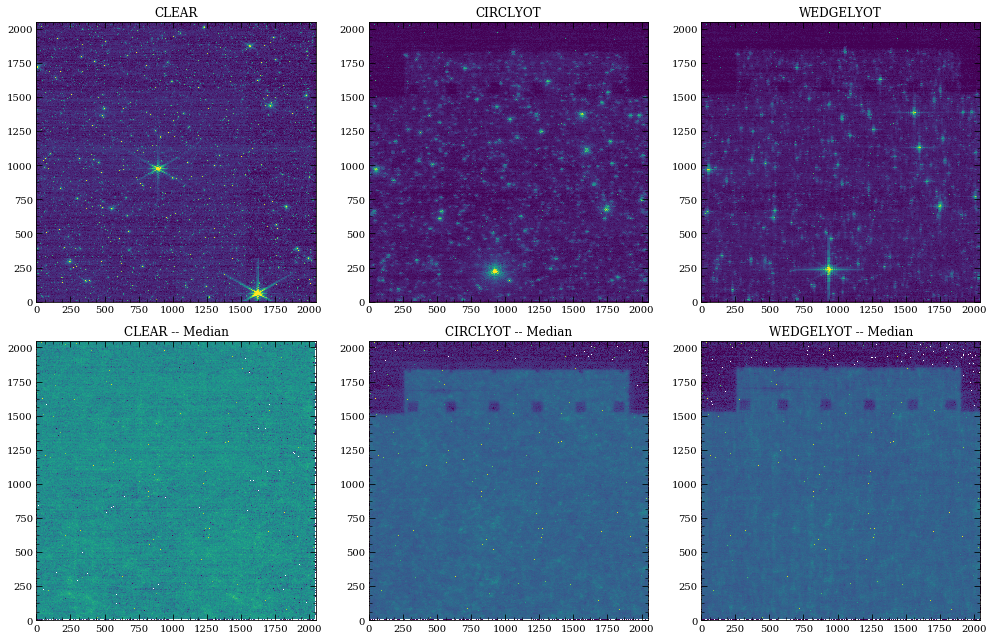

In [267]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2,3, figsize=(14,9))

title_arr = ['CLEAR', 'CIRCLYOT', 'WEDGELYOT']
for i, ax in enumerate(axes[0]):
    slope = file_ex[i]
    offset = slope.min()
    slope = slope - offset
    vmin = 1 if i==0 else 1e-1
    ax.imshow(slope, norm=LogNorm(vmin=vmin, vmax=1e2))
    ax.set_title(title_arr[i])
    
for i, ax in enumerate(axes[1]):
    slope = slopes_all[i]
    if i>2:
        vmin = np.median(slope[1800:,:])
        _vmin = nrc_utils.robust.medabsdev(slope[1800:,:])
        vmax = np.median(slope[0:1400,:])
        _vmax = nrc_utils.robust.medabsdev(slope[0:1400,:])
        ax.imshow(slope, vmin=vmin+3*_vmin, vmax=vmax-3*_vmax)
    else:
        ax.imshow(slope, norm=LogNorm(vmin=1e-2, vmax=1e1))
    ax.set_title(title_arr[i] + ' -- Median')
    
fig.tight_layout()
plt.savefig('simulations.pdf')

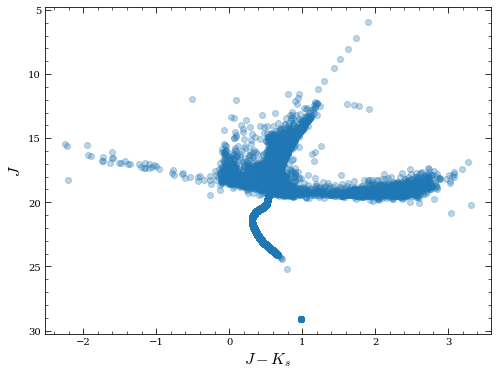

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(data['juse'] - data['kuse'], data['juse'], marker='o', alpha=0.3, ls='None')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel("$J-K_s$", fontsize=16)
ax.set_ylabel("$J$", fontsize=16);

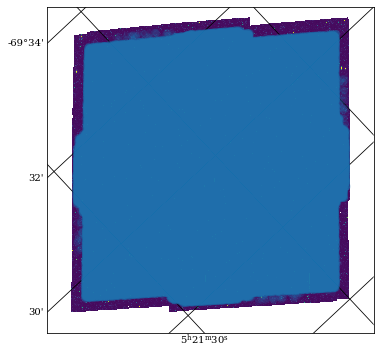

In [20]:
ax = plt.subplot(projection=wcs)
ax.imshow(hdu.data**0.5)
plt.grid(color='black')
plt.tick_params(axis='both', which='major', grid_linestyle='solid', grid_color='black')
plt.tick_params(axis='both', which='major', length=0)
plt.tick_params(axis='both', which='minor', length=0)
ax.plot_coord(coord, marker='o', alpha=0.1, ls='None')

In [60]:
v2_arr, v3_arr = test.closed_polygon_points('tel', rederive=False)

In [55]:
test.corners('tel', False)

(array([ 153.00343779, -153.78019453, -152.1177266 ,  150.82568334]),
 array([-559.38956414, -557.12846686, -425.99704897, -428.14868803]))

In [38]:
att = pysiaf.utils.rotations.attitude(test.V2Ref, test.V3Ref, 80.48750, -69.49750, 0)

In [67]:
ra_arr, dec_arr = pysiaf.utils.rotations.pointing(att, v2_arr, v3_arr)
ap_coord = SkyCoord(ra_arr, dec_arr, unit='deg', frame='icrs') 

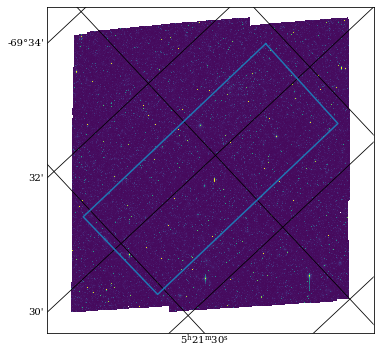

In [70]:
ax = plt.subplot(projection=wcs)
ax.imshow(hdu.data**0.5)
plt.grid(color='black')
plt.tick_params(axis='both', which='major', grid_linestyle='solid', grid_color='black')
plt.tick_params(axis='both', which='major', length=0)
plt.tick_params(axis='both', which='minor', length=0)
ax.plot_coord(ap_coord)

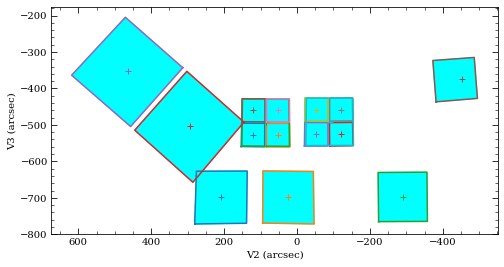

In [25]:
list(siaf.apernames)

['NRCA1_FULL_OSS',
 'NRCA2_FULL_OSS',
 'NRCA3_FULL_OSS',
 'NRCA4_FULL_OSS',
 'NRCA5_FULL_OSS',
 'NRCB1_FULL_OSS',
 'NRCB2_FULL_OSS',
 'NRCB3_FULL_OSS',
 'NRCB4_FULL_OSS',
 'NRCB5_FULL_OSS',
 'NRCALL_FULL',
 'NRCAS_FULL',
 'NRCA1_FULL',
 'NRCA2_FULL',
 'NRCA3_FULL',
 'NRCA4_FULL',
 'NRCA5_FULL',
 'NRCBS_FULL',
 'NRCB1_FULL',
 'NRCB2_FULL',
 'NRCB3_FULL',
 'NRCB4_FULL',
 'NRCB5_FULL',
 'NRCB1_FULLP',
 'NRCB5_FULLP',
 'NRCA1_SUB160',
 'NRCA2_SUB160',
 'NRCA3_SUB160',
 'NRCA4_SUB160',
 'NRCA5_SUB160',
 'NRCB1_SUB160',
 'NRCB2_SUB160',
 'NRCB3_SUB160',
 'NRCB4_SUB160',
 'NRCB5_SUB160',
 'NRCA1_SUB320',
 'NRCA2_SUB320',
 'NRCA3_SUB320',
 'NRCA4_SUB320',
 'NRCA5_SUB320',
 'NRCB1_SUB320',
 'NRCB2_SUB320',
 'NRCB3_SUB320',
 'NRCB4_SUB320',
 'NRCB5_SUB320',
 'NRCA1_SUB640',
 'NRCA2_SUB640',
 'NRCA3_SUB640',
 'NRCA4_SUB640',
 'NRCA5_SUB640',
 'NRCB1_SUB640',
 'NRCB2_SUB640',
 'NRCB3_SUB640',
 'NRCB4_SUB640',
 'NRCB5_SUB640',
 'NRCA5_GRISM256_F322W2',
 'NRCA5_GRISM128_F322W2',
 'NRCA5_GRISM64_F322

In [250]:
siaf = pysiaf.Siaf('NIRCAM')
ap = siaf['NRCA5_FULL']
ap2 = siaf['NRCA5_GRISMC_WFSS']
ap3 = siaf['NRCA5_GRISMR_WFSS']

ap4 = siaf['NRCB5_GRISMC_WFSS']
ap5 = siaf['NRCB5_GRISMR_WFSS']

ap6 = siaf['NRCA5_FULL_MASK335R']

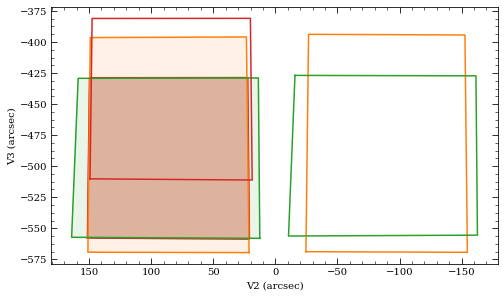

In [251]:
ap.plot(color='C3', fill=True, fill_color='C3', fill_alpha=0.3)

ap2.plot(color='C1', fill=True, fill_color='C1', fill_alpha=0.1)
ap3.plot(color='C2', fill=True, fill_color='C2', fill_alpha=0.1)

ap4.plot(color='C1', fill=False)
ap5.plot(color='C2', fill=False)

ap6.plot(color='C3', fill=False)

In [259]:
ap7 = siaf['NRCA5_MASK430R']


In [260]:
ap7.reference_point('tel')

(87.241565, -404.919331)

In [261]:
nrca5_mask.convert(ap7.reference_point('tel')[0], ap7.reference_point('tel')[1], 'tel', 'det')

(1077.9994114119522, 1673.021029626501)